In [44]:
# required google colab installations
# !pip install torchinfo torchmetrics wandb mlxtend==0.22

In [45]:
# import libraries
import random
import math
from pathlib import Path
import sys

from tqdm.auto import tqdm


import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import torchinfo # show model summary

# helper functions 
#from helpers import display_images

# pytorch modules
import torch
from torch.utils.data import DataLoader

# torch vision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn

# metrics module
import torchmetrics

# tracking metrics
import wandb

##### Hyper-parameter Initialisations

In [46]:
config = dict(
    epochs=15,
    learning_rate=1e-3,
    batch_size= 32,
    optimiser="SGD",
    dataset="MNIST",
    architecture="GoogLeNet",
)

In [47]:
run_name = f"{config['architecture']}_{config['optimiser']}_{config['learning_rate']}_{config['batch_size']}_{config['dataset']}"
print(run_name)

GoogLeNet_SGD_0.001_32_MNIST


In [48]:
# initialise wandb project
wandb.init(project="ECS795P_Classic", config=config, name=run_name)

In [49]:
config = wandb.config
print(f"Hyper-parameter configurations: \n{config}")

Hyper-parameter configurations: 
{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 32, 'optimiser': 'SGD', 'dataset': 'MNIST', 'architecture': 'GoogLeNet'}


In [50]:
def display_images(image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    #n_rows, n_cols = 3, 5
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        axs[i%n_rows, i//n_rows].set_title(class_labels[label[i]])
        
    return fig

In [51]:
def display_predicted_images(model, image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))

    model = model.to("cpu")

    model.eval()
    with torch.inference_mode():
        model_predictions_logits = model(data)
        predictions = nn.functional.softmax(model_predictions_logits, dim=0).argmax(dim=1)

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        title = f"Actual Class {class_labels[label[i]]}\n Predicted Class: {class_labels[predictions[i]]}"
        axs[i%n_rows, i//n_rows].set_title(title)

    return fig

In [52]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current hardware device: {DEVICE}")

Current hardware device: cuda


#### Downloading and Loading Datasets

In [53]:
# image Transforms
image_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
    ])


In [54]:
# load MNIST datasets
# MNIST train data
train_data = datasets.MNIST(
    root="mnist_data",
    train=True,
    transform=image_tranforms,
    download=True,
)

# MNIST test data
test_data = datasets.MNIST(
    root="mnist_data",
    train=False,
    transform=image_tranforms,
    download=True,
)

In [55]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Image size: {np.array(train_data[0][0].shape)}")

Train data size: 60000
Test data size: 10000
Image size: [  3 224 224]


In [56]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=config.batch_size,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=config.batch_size,
)

In [57]:
class_labels = train_data.classes # images class labels
print(f"class labels: {class_labels}")

class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


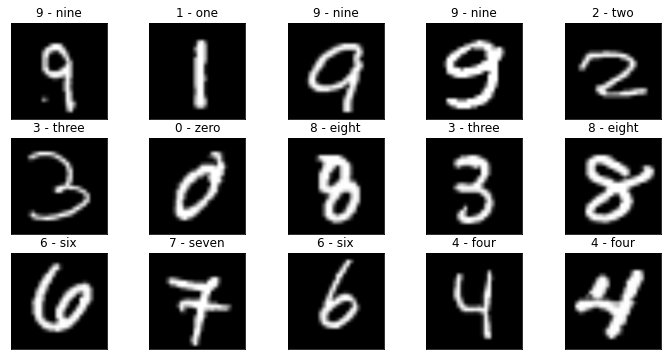

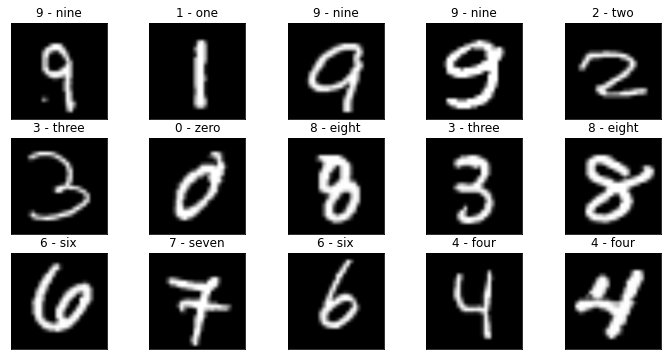

In [58]:
display_images(train_dataloader, class_labels=class_labels, n_cols=5, n_rows=3)

#### GoogLeNet Baseline Model

In [59]:
googlenet_model = torchvision.models.googlenet()

/home/mustious/anaconda3/envs/ECS795P/lib/python3.7/site-packages/torchvision/models/googlenet.py:51: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [60]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [61]:
# set the output of the FC layers to number of classes of MNIST

googlenet_mnist_fc = nn.Linear(in_features=1024, out_features=len(class_labels), bias=True)
googlenet_model.fc = googlenet_mnist_fc

In [62]:
# display model architecture
torchinfo.summary(googlenet_model,
                  input_size=(32, 3, 224, 224), 
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=60,
                  row_settings=["var_names"]
                  )

Layer (type (var_name))                  Input Shape                                                  Output Shape                                                 Param #                                                      Trainable
GoogLeNet (GoogLeNet)                    [32, 3, 224, 224]                                            [32, 10]                                                     6,379,984                                                    True
├─BasicConv2d (conv1)                    [32, 3, 224, 224]                                            [32, 64, 112, 112]                                           --                                                           True
│    └─Conv2d (conv)                     [32, 3, 224, 224]                                            [32, 64, 112, 112]                                           9,408                                                        True
│    └─BatchNorm2d (bn)                  [32, 64, 112, 112]                    

In [63]:
loss_fn = nn.CrossEntropyLoss()
if config.optimiser == "SGD":
    optimiser = torch.optim.SGD(googlenet_model.parameters(), lr=config.learning_rate)
elif config.optimiser == "ADAM":
    optimiser = torch.optim.Adam(googlenet_model.parameters(), lr=config.learning_rate)

In [64]:
# metrics definition
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [65]:
# monitor parameter values i.e weights and biases and model gradients
wandb.watch(googlenet_model, criterion=loss_fn, log="all")

[]

In [70]:
def train_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    train_acc, train_loss = 0, 0
    model.train()
    for batch_data, batch_label in train_dataloader:
        batch_data = batch_data.to(DEVICE)
        batch_label = batch_label.to(DEVICE)\

        pred = model(batch_data)
        pred_logits = pred.logits

        train_batch_loss = loss_fn(pred_logits, batch_label)
        train_loss += train_batch_loss

        preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
        
        train_batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
        train_acc += train_batch_acc

        optimiser.zero_grad()

        train_batch_loss.backward()

        optimiser.step()
    
    # average of metrics per batch
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    return train_loss, train_acc

In [71]:
def test_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    test_loss, test_acc =  0, 0
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)

            test_batch_loss = loss_fn(pred_logits, test_batch_label)
            test_loss += test_batch_loss

            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            batch_acc = accuracy_metric(preds.cpu(), test_batch_label.cpu()) * 100
            test_acc += batch_acc
        
        # average of loss metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [72]:
def model_prediction(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    all_preds = []
    model.to(DEVICE)
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)
            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            all_preds.append(preds.to("cpu"))
        
    all_preds_tensor = torch.cat(all_preds)
    return all_preds_tensor

##### Model Training

In [73]:

for epoch in tqdm(range(config.epochs)):

    # MODEL TRAINING
    train_loss, train_accuracy = train_model(googlenet_model, train_dataloader)

    # MODEL EVALUATION
    test_loss, test_accuracy = test_model(googlenet_model, test_dataloader)
    
    # print training metrics
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss: .3f}\t Training accuracy: {train_accuracy: .3f}", end="\t")
    print(f"Test loss: {test_loss: .3f}\t Test acc: {test_accuracy: .3f}")

    # log epoch metrics to WandB
    epoch_log_dict = {
        "training_accuracy": train_accuracy,
        "training_loss": train_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    wandb.log(epoch_log_dict)



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
Training loss:  0.371	 Training accuracy:  90.713	Test loss:  0.054	 Test acc:  96.296


### Visualisations

#### Model accuracy and loss


In [ ]:
# show logged metrics
%wandb mustious/ECS795P_Classic

#### Sample Images of Predicted Classes

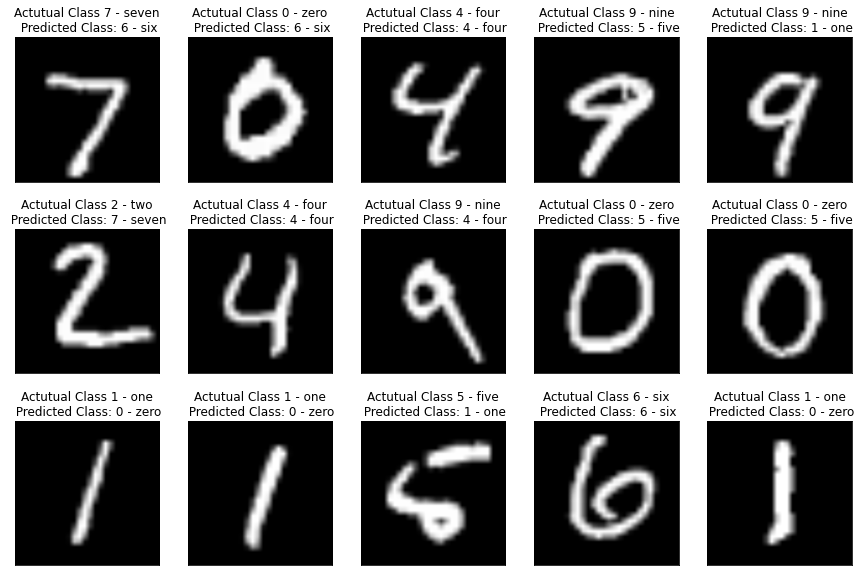

In [ ]:
predicted_images_fig = display_predicted_images(googlenet_model, test_dataloader, class_labels=class_labels, figsize=(15,10))
plt.savefig(f"{config.architecture}_sample_model_prediction.jpg")
plt.show()

# log prediction image in wandb
wandb.log({"sample_predictions": predicted_images_fig})

### Confusion Matrix Visualisation


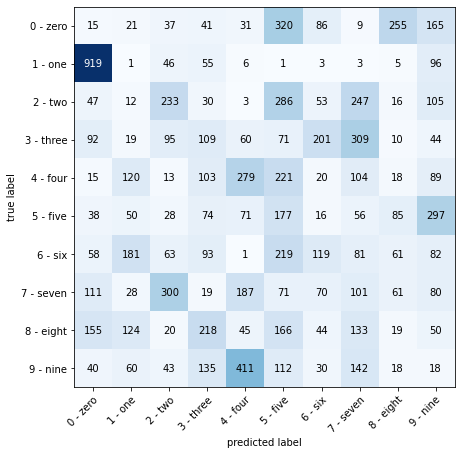

In [ ]:
predictions = model_prediction(googlenet_model, test_dataloader)

confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_labels))
confusion_matrix_tensor = confusion_matrix(predictions, test_data.targets)

confusion_matrix_fig, ax = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names= class_labels,
    figsize=(10, 7))
plt.show()

# log prediction image in wandb
wandb.log({"confusion_matrix": confusion_matrix_fig})